In [1]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import kagglehub
import shutil
import os

dataset_path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
current_dir = os.getcwd()  

for filename in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path, filename)
    shutil.move(file_path, current_dir)

print(f"¡Dataset descargado en: {current_dir}")
print("Archivos:", os.listdir(current_dir ))


C:\Users\IABD12\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


¡Dataset descargado en: c:\Users\IABD12\Documents\GitHub\ClaseIABD\PIA\Prueba Grupal
Archivos: ['aam.txt', 'diabetes_binario_2015.csv', 'PruebaGrupalAAM.ipynb']


## Columnas ideales para modelos (XGBoost/Gradient Boosting)

Estas variables permiten explotar relaciones no lineales o jerárquicas en modelos de machine learning:

### BMI (Continuous)  
**Descripción**: Índice de Masa Corporal (valor numérico continuo)  
**Importancia**: Factor clave para diabetes y enfermedades metabólicas  

### GenHlth (Ordinal: 1-5)  
**Descripción**: Autoevaluación de salud general:  
- 1 = Excelente  
- 2 = Muy buena  
- 3 = Buena  
- 4 = Regular  
- 5 = Mala  
**Uso**: Relación subjetiva pero potente con condiciones crónicas  

### MentHlth (Continuous: 0-30)  
**Descripción**: Días de mala salud mental en los últimos 30 días  
**Nota**: Valores altos pueden correlacionar con estrés crónico (impacta diabetes)  

### PhysHlth (Continuous: 0-30)  
**Descripción**: Días de mala salud física en los últimos 30 días  
**Ejemplo**: Dolor crónico o limitaciones físicas  

### Age (Ordinal: 1-13)  
**Descripción**: Grupos de edad codificados:  
- 1 = 18-24 años  
- 2 = 25-29  
- ...  
- 13 = 80+ años  
**Relevancia**: La edad es un predictor fuerte de diabetes tipo 2  

### Education (Ordinal: 1-6)  
**Descripción**: Nivel educativo:  
- 1 = Sin educación formal  
- ...  
- 6 = Universitario o superior  
**Contexto**: Menor educación puede asociarse a menos acceso a salud preventiva  

### Income (Ordinal: 1-8)  
**Descripción**: Rango de ingresos anuales:  
- 1 = <$10,000  
- ...  
- 8 = >$75,000  
**Uso**: El nivel socioeconómico afecta acceso a alimentación saludable y ejercicio  

## Gradient Boosting (Alejandro Cruz)

### Correlación de las variables en el dataset

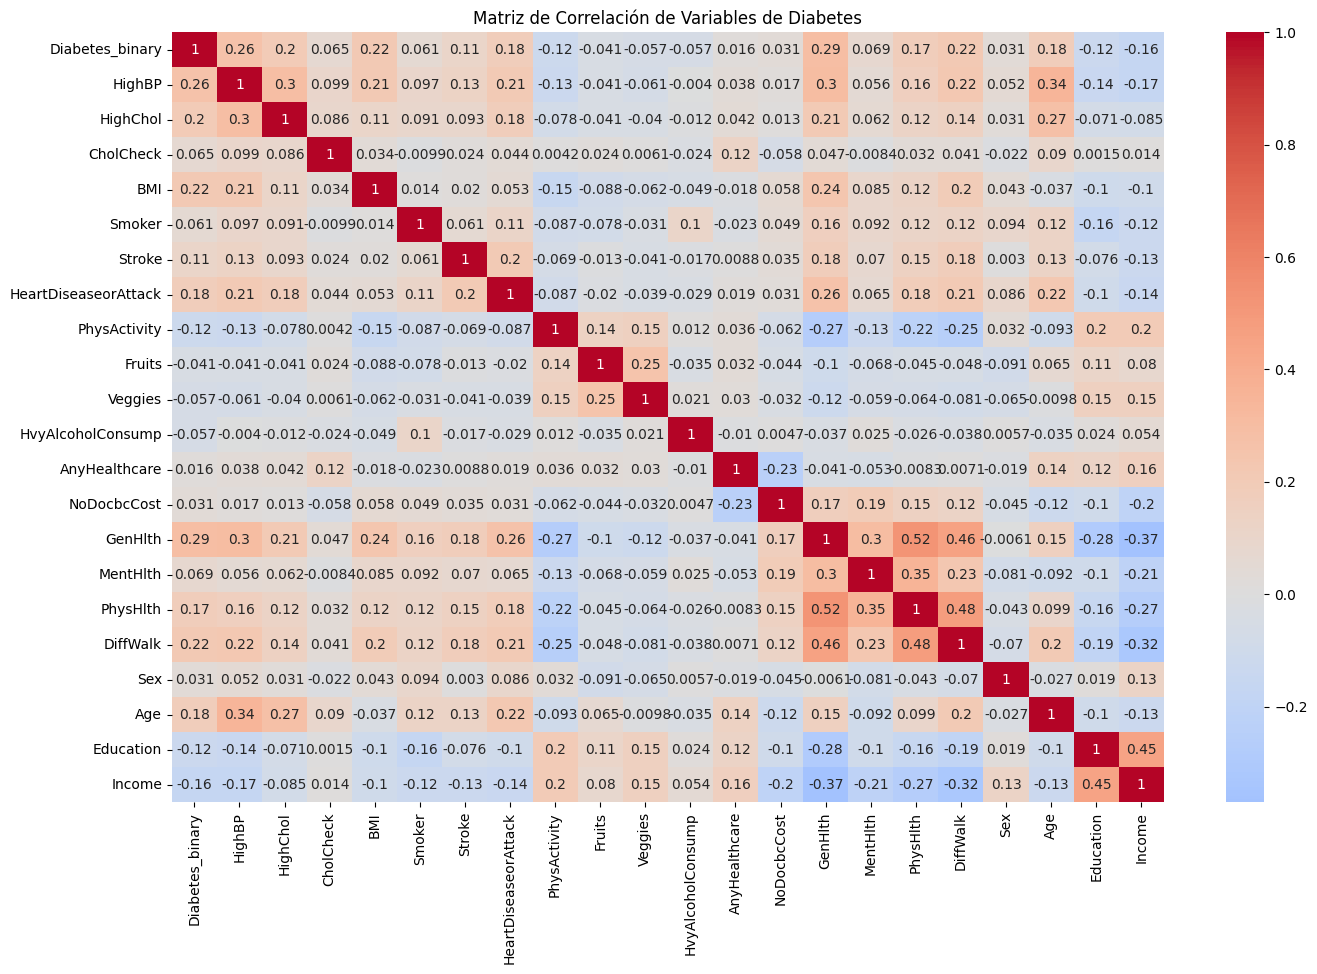

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('diabetes_binario_2015.csv')

correlation_matrix = data.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Variables de Diabetes')
plt.show()

### Limpieza de datos de las columnas menos relevantes

In [4]:
low_corr_vars = [
    'Stroke', 'MentHlth', 'CholCheck', 'Smoker', 'NoDocbcCost', 
    'Sex', 'AnyHealthcare', 'Fruits', 'Veggies', 'HvyAlcoholConsump'
]
data_clean = data.drop(columns=low_corr_vars)
print(data_clean.isnull().sum())
data_clean = data_clean.dropna()

Diabetes_binary         0
HighBP                  0
HighChol                0
BMI                     0
HeartDiseaseorAttack    0
PhysActivity            0
GenHlth                 0
PhysHlth                0
DiffWalk                0
Age                     0
Education               0
Income                  0
dtype: int64


### One Hot Encoding de los datos + Escalado


In [ ]:
# Importamos StandardScaler para estandarizar las variables numéricas
from sklearn.preprocessing import StandardScaler

# Creamos una instancia del escalador
scaler = StandardScaler()

# Lista de columnas numéricas que vamos a estandarizar
num_vars = ['BMI', 'Age', 'PhysHlth', 'HighBP', 'GenHlth', 'DiffWalk', 'HighChol']

# Aplicamos la estandarización: media 0, desviación estándar 1
# fit_transform calcula los parámetros y transforma los datos
data_clean[num_vars] = scaler.fit_transform(data_clean[num_vars])

### Aplicamos SMOTE si el desbalance de los datos es demasiado grande

In [ ]:
# Convertimos las variables categóricas 'Education' e 'Income' en variables dummy (0 y 1)
# drop_first=True elimina la primera categoría para evitar colinealidad
data_clean = pd.get_dummies(data_clean, columns=['Education', 'Income'], drop_first=True)

# Importamos SMOTE (Synthetic Minority Over-sampling Technique) para balancear clases desbalanceadas
from imblearn.over_sampling import SMOTE

# Separamos las características (X) de la variable objetivo (y)
X = data_clean.drop('Diabetes_binary', axis=1)  # Todas las columnas menos 'Diabetes_binary'
y = data_clean['Diabetes_binary']               # Variable objetivo

# Verificamos si hay un desbalance significativo en la clase
# Si más del 70% de los datos pertenecen a una sola clase (y[0]), aplicamos SMOTE
if y.value_counts()[0] / len(y) > 0.7:
    # Aplicamos SMOTE para generar ejemplos sintéticos de la clase minoritaria
    X, y = SMOTE().fit_resample(X, y)

    # Reconstruimos el DataFrame original incluyendo las nuevas muestras
    data_clean = pd.concat([X, y], axis=1)

### Eliminar datos extremos del BMI. (Si son muy altos o muy bajos directamente deberian estar muertos por otras cosas)

In [ ]:
# Para la variable BMI, eliminamos valores extremos (outliers)
# Calculamos el percentil 5 (Q1) y el percentil 95 (Q3) de la columna 'BMI'
Q1 = data_clean['BMI'].quantile(0.05)  # Límite inferior (5% más bajo)
Q3 = data_clean['BMI'].quantile(0.95)  # Límite superior (5% más alto)

# Filtramos el DataFrame conservando solo los valores dentro del rango [Q1, Q3]
# Es decir, eliminamos el 5% más bajo y el 5% más alto para reducir el efecto de los outliers
data_clean = data_clean[(data_clean['BMI'] >= Q1) & (data_clean['BMI'] <= Q3)]

### Comprobacion de los datasets

In [8]:
print(f"Dataset original: {data.shape}")
print(f"Dataset limpio: {data_clean.shape}")
print("\nVariables finales:", list(data_clean.columns))

Dataset original: (253680, 22)
Dataset limpio: (399333, 22)

Variables finales: ['HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack', 'PhysActivity', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education_2.0', 'Education_3.0', 'Education_4.0', 'Education_5.0', 'Education_6.0', 'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0', 'Income_6.0', 'Income_7.0', 'Income_8.0', 'Diabetes_binary']


## Entrenamientos de los datos

In [ ]:
# Importación de las funciones necesarias de scikit-learn
from sklearn.model_selection import train_test_split  # Para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.preprocessing import StandardScaler       # Para escalar/normalizar los datos
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Métricas para evaluar el modelo

# Separación de los datos en características (X) y etiquetas (y)
X = data.drop('Diabetes_binary', axis=1)  # Se eliminan las etiquetas del dataframe para quedarse solo con las variables predictoras
y = data['Diabetes_binary']               # Se selecciona la columna objetivo (etiqueta), que indica si hay diabetes o no

# División del conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X, y, test_size=0.2, random_state=38)
# random_state se establece para que los resultados sean reproducibles (siempre la misma partición)

# Creación del escalador para normalizar los datos
scaler = StandardScaler()

# Ajuste del escalador solo con los datos de entrenamiento y transformación (normalización)
X_train_scaled = scaler.fit_transform(X_train_B)

# Transformación del conjunto de prueba con los parámetros aprendidos del entrenamiento
X_test_scaled = scaler.transform(X_test_B)


## GradientBoostingClassifier (Problematico a más no poder)

Accuracy: 0.8575

Matriz de Confusión Optimizada:


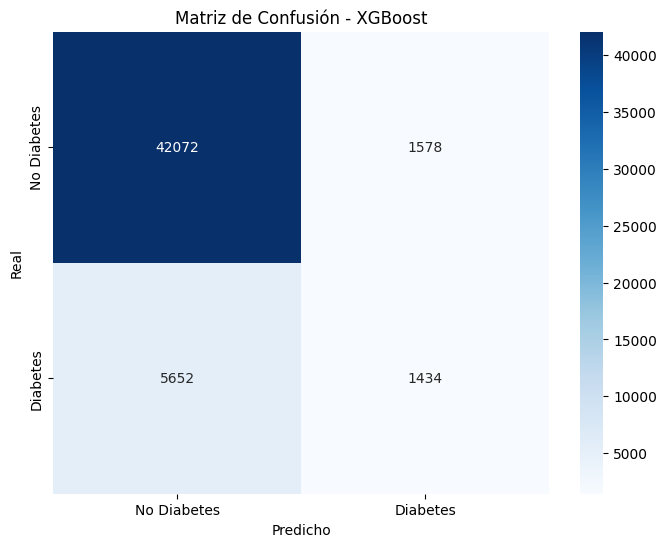


Reporte de Clasificación Mejorado:
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     43650
         1.0       0.48      0.20      0.28      7086

    accuracy                           0.86     50736
   macro avg       0.68      0.58      0.60     50736
weighted avg       0.82      0.86      0.83     50736



In [ ]:
# Importamos el modelo de Gradient Boosting y métricas para evaluar
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Creamos el modelo de Gradient Boosting con parámetros ajustados
gb_model = GradientBoostingClassifier(
    n_estimators=150,         # Número de árboles (estimadores)
    learning_rate=1,          # Tasa de aprendizaje (más alto = más agresivo)
    max_depth=5,              # Profundidad máxima de cada árbol
    min_samples_split=20,     # Mínimo de muestras para dividir un nodo
    min_samples_leaf=10,      # Mínimo de muestras en una hoja
    max_features='sqrt',      # Número de features consideradas al dividir (raíz cuadrada del total)
    subsample=0.7,            # Fracción de muestras usadas en cada árbol (bagging)
    random_state=38           # Semilla para reproducibilidad
)

# Entrenamos el modelo con los datos de entrenamiento
gb_model.fit(X_train_B, y_train_B)

# Realizamos predicciones sobre el conjunto de prueba
y_pred_B_1 = gb_model.predict(X_test_B)

# Mostramos la precisión del modelo
print(f"Accuracy: {accuracy_score(y_test_B, y_pred_B_1):.4f}")

# Mostramos la matriz de confusión en forma de heatmap
print("\nMatriz de Confusión Optimizada:")
cm = confusion_matrix(y_test_B, y_pred_B_1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Matriz de Confusión - XGBoost')  # Nota: aquí deberías cambiar "XGBoost" por "Gradient Boosting"
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Mostramos métricas más detalladas (precision, recall, f1-score)
print("\nReporte de Clasificación Mejorado:")
print(classification_report(y_test_B, y_pred_B_1))

## XGBoost (El bueno)

[0]	validation_0-logloss:0.66808
[10]	validation_0-logloss:0.56064
[20]	validation_0-logloss:0.53115
[30]	validation_0-logloss:0.51988
[40]	validation_0-logloss:0.51516
[50]	validation_0-logloss:0.51311
[60]	validation_0-logloss:0.51163
[70]	validation_0-logloss:0.51059
[80]	validation_0-logloss:0.50993
[90]	validation_0-logloss:0.51004
[100]	validation_0-logloss:0.50962
[110]	validation_0-logloss:0.50923
[120]	validation_0-logloss:0.50872
[130]	validation_0-logloss:0.50880
[140]	validation_0-logloss:0.50876
[150]	validation_0-logloss:0.50793
[160]	validation_0-logloss:0.50813
[170]	validation_0-logloss:0.50822
[180]	validation_0-logloss:0.50807
[190]	validation_0-logloss:0.50767
[199]	validation_0-logloss:0.50729
📊 Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.81     43650
         1.0       0.31      0.80      0.45      7086

    accuracy                           0.72     50736
   macro avg       0.63      0

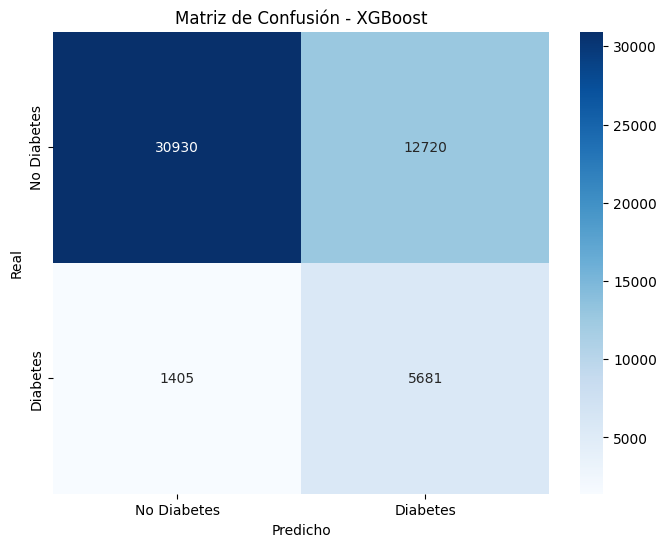

In [ ]:
# Importamos XGBoost y herramientas de evaluación
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configuramos el clasificador XGBoost con hiperparámetros ajustados
model = xgb.XGBClassifier(
    n_estimators=200,       # Número de árboles
    learning_rate=0.1,      # Tasa de aprendizaje (más bajo = más estable)
    max_depth=4,            # Profundidad máxima de los árboles
    subsample=0.8,          # Fracción de datos usada en cada iteración (reducción de overfitting)
    colsample_bytree=0.8,   # Fracción de features consideradas por árbol
    reg_alpha=0.1,          # Regularización L1 (reduce complejidad del modelo)
    reg_lambda=0.1,         # Regularización L2 (evita overfitting)
    
    # Peso para manejar desbalance de clases (clase 0 vs clase 1)
    scale_pos_weight=len(y_train_B[y_train_B==0]) / len(y_train_B[y_train_B==1]),

    random_state=38,  # Semilla para reproducibilidad
    eval_metric='logloss'  # Métrica de evaluación durante el entrenamiento
)

# Entrenamos el modelo, mostrando el progreso con verbose
model.fit(
    X_train_B, 
    y_train_B,
    eval_set=[(X_test_B, y_test_B)],  # Conjunto de validación para monitorear performance
    verbose=10  # Muestra el log de cada 10 árboles
)

# Hacemos predicciones sobre el conjunto de prueba
y_pred_B_2 = model.predict(X_test_B)

# Mostramos el reporte de clasificación
print("📊 Reporte de Clasificación:")
print(classification_report(y_test_B, y_pred_B_2))

# Calculamos y graficamos la matriz de confusión
cm = confusion_matrix(y_test_B, y_pred_B_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()


## Regresión Lineal y Polinómica(Álvaro Prado)

Importacion de librerias

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

Carga de datos y limpieza del dataset

In [33]:
# Cargar el archivo CSV
file_path = "diabetes_binario_2015.csv"
df = pd.read_csv(file_path)

# Convertir todas las columnas a tipo numérico
df = df.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
df_clean = df.dropna()

# Eliminar duplicados
df_clean = df_clean.drop_duplicates()


Selección de variables y división de datos

In [34]:
# Seleccionar las variables
X = df_clean[['BMI']].values  # Variable independiente
y = df_clean['Diabetes_binary'].values  # Variable dependiente

# Dividir en conjunto de entrenamiento y prueba
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X, y, test_size=0.2, random_state=42)


Regresión Lineal

In [35]:
# Regresión Lineal

# Se crea una instancia del modelo de regresión lineal
lin_reg = LinearRegression()

# Se entrena el modelo usando los datos de entrenamiento (BMI como entrada y diabetes como salida)
lin_reg.fit(X_train_A, y_train_A)

# Se hacen predicciones sobre los datos de prueba usando el modelo entrenado
y_pred_lin = lin_reg.predict(X_test_A)


Regresión Polinómica (grado 2)

In [36]:
# Regresión Polinómica (grado 2)

# Se crea una transformación para generar características polinómicas de grado 2
poly = PolynomialFeatures(degree=2)

# Se transforma X_train_A para incluir términos polinómicos (por ejemplo, BMI y BMI^2)
X_poly = poly.fit_transform(X_train_A)

# Se crea una nueva instancia del modelo de regresión lineal (que ahora usará los términos polinómicos)
poly_reg = LinearRegression()

# Se entrena el modelo con los datos polinómicos transformados
poly_reg.fit(X_poly, y_train_A)

# Se transforma el conjunto de prueba con la misma transformación polinómica
X_test_poly = poly.transform(X_test_A)

# Se hacen predicciones con el modelo polinómico sobre los datos de prueba transformados
y_pred_poly = poly_reg.predict(X_test_poly)


Evaluacion de modelos

In [38]:
# ---- Evaluación del modelo de regresión lineal como clasificador ----

# Se redondean las predicciones de regresión lineal a 0 o 1 para hacer clasificación
y_pred_lin_class = np.round(y_pred_lin)

# Calcula la exactitud del modelo (porcentaje de predicciones correctas)
accuracy = accuracy_score(y_test_A, y_pred_lin_class)

# Genera la matriz de confusión
conf_matrix = confusion_matrix(y_test_A, y_pred_lin_class)

# Genera el reporte de clasificación: precisión, recall y F1-score
class_report = classification_report(y_test_A, y_pred_lin_class)

# ---- Formato de salida ----

print(f"Exactitud de la Regresión Lineal como Clasificador: {accuracy:.4f}\n")
print("Matriz de Confusión:")
print(conf_matrix, "\n")
print("Reporte de Clasificación:")
print(class_report)


Exactitud de la Regresión Lineal como Clasificador: 0.8439

Matriz de Confusión:
[[38690   123]
 [ 7043    39]] 

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92     38813
         1.0       0.24      0.01      0.01      7082

    accuracy                           0.84     45895
   macro avg       0.54      0.50      0.46     45895
weighted avg       0.75      0.84      0.78     45895



 Visualización de resultados

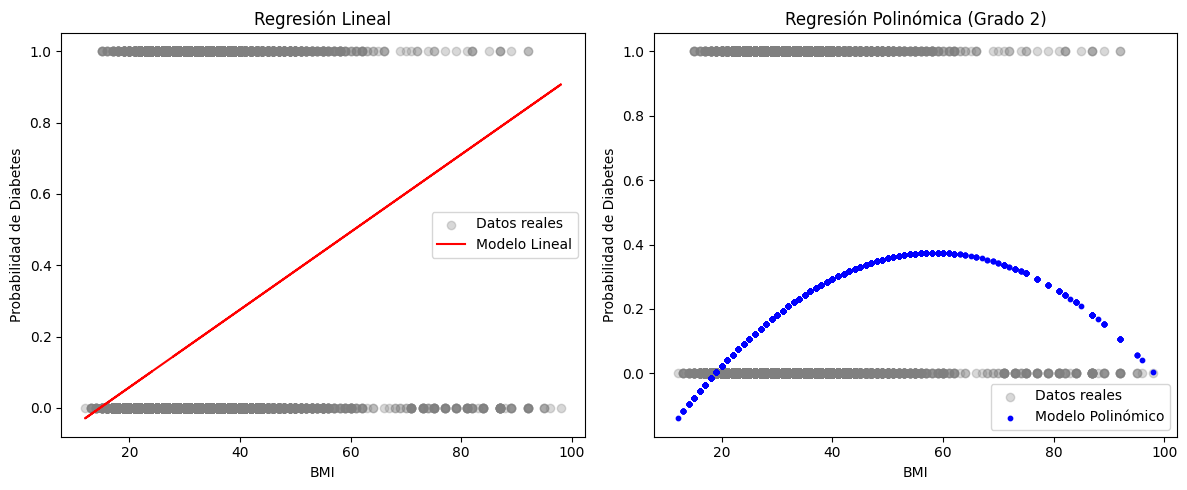

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1️⃣ Gráfico de la regresión lineal
ax[0].scatter(X_test_A, y_test_A, color="gray", alpha=0.3, label="Datos reales")
ax[0].plot(X_test_A, y_pred_lin, color="red", label="Modelo Lineal")
ax[0].set_title("Regresión Lineal")
ax[0].set_xlabel("BMI")
ax[0].set_ylabel("Probabilidad de Diabetes")
ax[0].legend()

# 2️⃣ Gráfico de la regresión polinómica
ax[1].scatter(X_test_A, y_test_A, color="gray", alpha=0.3, label="Datos reales")
ax[1].scatter(X_test_A, y_pred_poly, color="blue", s=10, label="Modelo Polinómico")
ax[1].set_title("Regresión Polinómica (Grado 2)")
ax[1].set_xlabel("BMI")
ax[1].set_ylabel("Probabilidad de Diabetes")
ax[1].legend()

plt.tight_layout()
plt.show()

## KNN (Miguel Sedano) 

1. Importación de librerías

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest, f_classif

2. Carga del dataset

In [41]:

df = pd.read_csv("diabetes_binario_2015.csv")

3. Limpieza del DataFrame

In [42]:

df.dropna(inplace=True)

4. Separar características y variable objetivo

In [43]:
X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"]

5. Selección y división

In [44]:
# Selección de características más relevantes
selector = SelectKBest(score_func=f_classif, k=10)  # Seleccionamos las 10 mejores características
X = selector.fit_transform(X, y)
# Dividir en conjunto de entrenamiento y prueba
X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

6. Balanceo de clases

In [46]:
# Aplicar ADASYN para balancear las clases
adasyn = ADASYN(random_state=42)
X_train_M, y_train_M = adasyn.fit_resample(X_train_M, y_train_M)

7. Normalización

In [ ]:
# Normalizar los datos
scaler = StandardScaler()
X_train_M = scaler.fit_transform(X_train_M)
X_test_M = scaler.transform(X_test_M)

8. Aplicación de KNN

In [ ]:
# Aplicar KNN con diferentes valores de K
k_values = range(3, 16) # De 3 a 15
accuracy_scores = []

# Recorremos diferentes valores de k
for k in k_values:
    # Creamos el modelo KNN con distancia Manhattan y pesos por distancia
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='distance', n_jobs=-1)
    
    # Entrenamos el modelo
    knn.fit(X_train_M, y_train_M)
    
    # Predecimos con los datos de prueba
    y_pred_M = knn.predict(X_test_M)
    
    # Guardamos la precisión en la lista
    accuracy_scores.append(accuracy_score(y_test_M, y_pred_M))

9. Gráfico

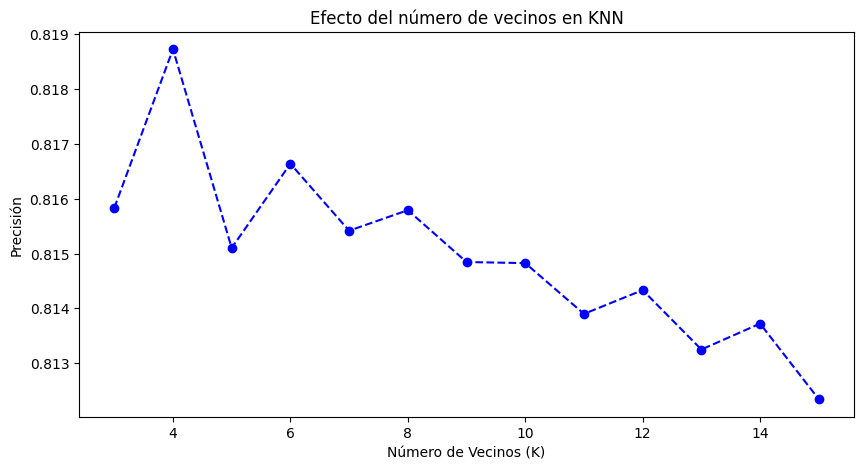

In [ ]:
# Graficar la precisión en función de K
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='dashed', color='b')
plt.xlabel('Número de Vecinos (K)')
plt.ylabel('Precisión')
plt.title('Efecto del número de vecinos en KNN')
plt.show()

10. Mejor valor de K

In [ ]:
# Selección del mejor K basado en la precisión máxima
best_k = k_values[np.argmax(accuracy_scores)]
print(f"Mejor valor de K: {best_k}")

Mejor valor de K: 4


11. Entrenamiento del modelo

In [ ]:
# Entrenar modelo con el mejor K
knn_best = KNeighborsClassifier(n_neighbors=best_k, metric='manhattan', weights='distance')
knn_best.fit(X_train_M, y_train_M)
y_pred_best = knn_best.predict(X_test_M)

12. Evaluación del modelo

In [ ]:
# Evaluación del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test_M, y_pred_best))

print("\nReporte de Clasificación:")
print(classification_report(y_test_M, y_pred_best))

Matriz de Confusión:
[[39284  4383]
 [ 4814  2255]]

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90     43667
         1.0       0.34      0.32      0.33      7069

    accuracy                           0.82     50736
   macro avg       0.62      0.61      0.61     50736
weighted avg       0.81      0.82      0.82     50736

